## Mortgage default detection with random forest model and SHAP Values

#### Author: Huizhe (Sunny) ZHU - hz2657

#### Date: 2020.12.05


**Background**

Based on previous weeks, this week's project focuses on model's interpretability by using SHAP (SHapley Additive exPlanations) value.  Our dataset is the 'loan default' dataset which contains 80000 applicants' information and whether they default or not. The SHAP value  is an important tool in Explainable AI.  SHAP values increase model transparency. SHapley value is the average of the marginal contributions across all permutations, we want to measure the contributions of each predictor in reducing the error.We will build a random forest regression model and will use the TreeExplainer in SHAP. 


Benefit of SHAP: 

1) global interpretability — the collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. (SHAP value plot)
2)  local interpretability — each observation gets its own set of SHAP values (individual SHAP value plot)
3)  SHAP values can be calculated for any tree-based model



**Notebook structure**

1. Load and explore data

2. Feature selection

3. EDA on selected features

4. Prepare Data and Fit model

5. SHAP values

** 5.1 SHAP explanation force plots 

** 5.2 SHAP Feature Importance

** 5.3 Summary Plot

** 5.4 SHAP Dependence Plot 



## 1. Load and explore data

- Load, clean data, match column names and description

In [1]:
# import dataset, the first 3 columns do not contain valid info, we will remove these them later
import numpy as np
import pandas as pd
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df.head(3)

# the dataset has 80,000 rows and 89 columns 

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB


the dataset has 19.3% default applications, indicates the dataset is imbalanced.

In [2]:
# examine number of rows and columns for the dataset: 19% default in total records
df['loan_default'].value_counts()/df['loan_default'].count()

0    0.8064
1    0.1936
Name: loan_default, dtype: float64

In [3]:
# explore column name: 85 independent variables after excluding the first 3 columns
# however, the names do not contain meanings directly, we need to connect with another data source to make sense of the column names in next step
columns_names = df.columns

### Match column names and description

In [4]:
# load another data source which contains column names' details
Variables_Dictionary = pd.read_excel('Variables_Dictionary_2019.xlsx')

In [5]:
# extract meaningful information 
Variables_Dictionary = Variables_Dictionary.loc[3:,]
Variables_Dictionary=Variables_Dictionary.drop(columns=['Unnamed: 0', 'Unnamed: 1','Unnamed: 3','Unnamed: 5'])
Variables_Dictionary.columns = ['var', 'description']

In [6]:
# create reference table contains descriptions for the variables in dataset  
# from the table below we can examine columns meanings 
Variables_Dictionary=Variables_Dictionary[Variables_Dictionary['var'].isin(columns_names[4:])]
Variables_Dictionary

,var,description
3,AP001,YR_AGE
4,AP002,CODE_GENDER
5,AP003,CODE_EDUCATION
6,AP004,LOAN_TERM
7,AP005,DATE_APPLIED
...,...,...
254,PA023,DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL
259,PA028,AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS
260,PA029,AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS
261,PA030,AVG_LEN_COLLECTION_OR_HIGH_RISK_OUTBOUND_CALLS


## 2. Feature selection

The dataset has 85 variables, before building the model, we perform variable selection first.


In [7]:
# drop first three columns which do not have valuable information, save it as df1
df1=df
df1 = df1.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','id'])

### 2.1 Examine missing values 

- From the table below, we can check the number of missing values for each column 

- For variables 'TD044', 'TD048','TD051','TD054','TD055','TD061','TD062', they have more than 79990 missing values and no variable description, we have 80000 rows in our dataset, in this case, we will drop these variables 

In [8]:
# set display max rows = 999 
pd.options.display.max_rows = 999

# examine missing value: more than half variables have missing values
na_summary = df1.isnull().sum() 
na_summary = pd.DataFrame(data=na_summary) 
na_summary['var'] = na_summary.index   # reset index 
na_summary.columns = ['num_missing_values','var']

# merge with Variables_Dictionary table 
pd.merge(na_summary, Variables_Dictionary, how='left', on='var')

,num_missing_values,var,description
0,0,loan_default,NaN
1,0,AP001,YR_AGE
2,0,AP002,CODE_GENDER
3,0,AP003,CODE_EDUCATION
4,0,AP004,LOAN_TERM
5,0,AP005,DATE_APPLIED
6,0,AP006,OS_TYPE
7,0,AP007,LEVEL_APPL_CITY
8,0,AP008,FLAG_IP_CITY_NOT_APPL_CITY
9,0,AP009,NaN


In [9]:
# drop variables that have more than 79990 missing values 
df1 = df1.drop(columns=['TD044', 'TD048','TD051','TD054','TD055','TD061','TD062'])
# drop DATE_APPLIED
df1 = df1.drop(columns=['AP005'])

### 2.2 Use correlation matrix for feature selection

- Correlation states how the features are related to each other. We exclude variables which have more than 0.9 correlation with another variable. 

- After this step, 56 columns left 

In [10]:
df1.columns

Index(['loan_default', 'AP001', 'AP002', 'AP003', 'AP004', 'AP006', 'AP007',
       'AP008', 'AP009', 'TD001', 'TD002', 'TD005', 'TD006', 'TD009', 'TD010',
       'TD013', 'TD014', 'TD015', 'TD022', 'TD023', 'TD024', 'TD025', 'TD026',
       'TD027', 'TD028', 'TD029', 'CR004', 'CR005', 'CR009', 'CR012', 'CR015',
       'CR017', 'CR018', 'CR019', 'PA022', 'PA023', 'PA028', 'PA029', 'PA030',
       'PA031', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101',
       'CD106', 'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118',
       'CD120', 'CD121', 'CD123', 'CD130', 'CD131', 'CD132', 'CD133', 'CD135',
       'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 'CD166',
       'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005', 'MB007'],
      dtype='object')

In [11]:
# get correlations of each features in dataset, it contains 83 rows 
corr = df1.corr()

# drop AP006, MB007 from df1 because it is not contained in correlation matrix 
df1 = df1.drop(columns=['AP006'])
df1 = df1.drop(columns=['MB007'])

In [12]:
# remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = df1.columns[columns]
df3 = df1[selected_columns]

In [13]:
# add AP006,MB007 back in the new dataset df3
df3['AP006'] = df.loc[:,'AP006']
df3['MB007'] = df.loc[:,'MB007']

C:\Users\Huizhe ZHU\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Huizhe ZHU\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
## check descriptions for what's left 
# Variables_Dictionary[Variables_Dictionary['var'].isin(df3.columns)]

### 2.3 Use decision tree importance values for feature selection

In step 5, we found variables have the least importance and most importance, we will keep the following variables: 

'TD009','TD013','TD005','TD014','PA028','CD115','TD024','AP004','PA031','AP003','CD131','MB005','CR004',
 'TD010', 'CR015','PA022','CD018','CR005','CR009','CD152','PA029','TD023','AP002','CD160','CD169','CD130','TD001','CD166',
 'CD088','CD008','CR017'
 
After this step, we have 30 varibles left. 

In [15]:
# only keep variables which have most importance in random forest model
df3 = df3.loc[:,['loan_default','TD009','TD013','TD005','TD014','PA028','CD115','TD024','AP004','PA031','AP003','AP006','CD131','MB005','CR004',
 'TD010', 'CR015','PA022','CD018','CR005','CR009','CD152','PA029','TD023','AP002','CD160','CD169','CD130','TD001','CD166',
 'CD008','CR017']]

## 3. EDA on selected features

- We have 30 features left to this point

In [16]:
# to make sense of the columns, we combine column names from selected features with Variables_Dictionary dataset
Variables_Dictionary[Variables_Dictionary['var'].isin(df3.columns)].head(8)

,var,description
4,AP002,CODE_GENDER
5,AP003,CODE_EDUCATION
6,AP004,LOAN_TERM
8,AP006,OS_TYPE
15,MB005,YR_PHONE_ACTIVE
20,CR004,CNT_QUERY_TIME_LAST_1MON
21,CR005,CNT_QUERY_TIME_LAST_2MON
25,CR009,AMT_LOAN_TOTAL


#### Select variables we want to explore: 

- AP001: age
- AP002: gender
- AP003: education
- AP004: LOAN_TERM
- CR015: MONTH_CREDIT_CARD_MOB_MAX

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0.5, 0, 'gender'), Text(0.5, 1.0, 'Distribution of gender')]

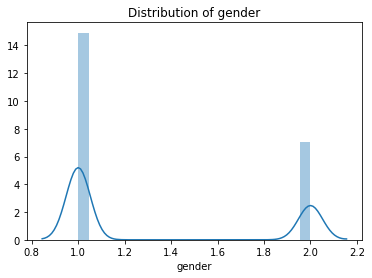

In [18]:
# Distribution of gender: more 1 than 2
sns.distplot(df3['AP002']).set(xlabel='gender', title = 'Distribution of gender')

[Text(0.5, 0, 'education'), Text(0.5, 1.0, 'Distribution of education')]

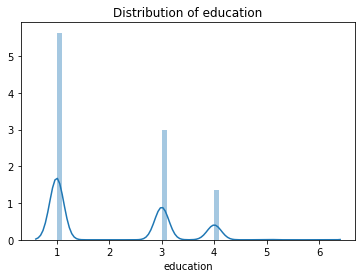

In [19]:
# Distribution of education: more 1 than 3 and 4
sns.distplot(df3['AP003']).set(xlabel='education', title = 'Distribution of education')

[Text(0.5, 0, 'LOAN_TERM'), Text(0.5, 1.0, 'Distribution of LOAN_TERM')]

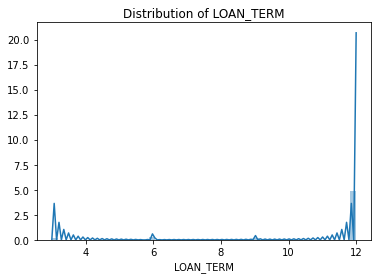

In [20]:
# Distribution of LOAN_TERM: more 12-months term application
sns.distplot(df3['AP004']).set(xlabel='LOAN_TERM', title = 'Distribution of LOAN_TERM')

## 4. Prepare Data and Fit model

### 4.1 Prepare Data 

In [21]:
# get X, y
y = df3['loan_default']
X = df3.loc[:, df3.columns != 'loan_default']

# deal with missing values
X=X.fillna(X.mean())

# AP006 is object
X=pd.get_dummies(X, columns=['AP006'])

### 4.2 Train model and make prediction by random forest

The random forest of scikit-learn needs you to create dummy variables for your categorical variables. 

AP006 is categorical variable, to apply random forest of scikit learn, we need to create dummy variable for it. 

In [22]:
# fit model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1, test_size = 0.2)
model_classifier = RandomForestClassifier(random_state=1).fit(train_X, train_y)

C:\Users\Huizhe ZHU\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [23]:
# accuracy score for test dataset 
model_classifier.score(test_X, test_y)

0.7995625

### 4.3 Evaluate model performance

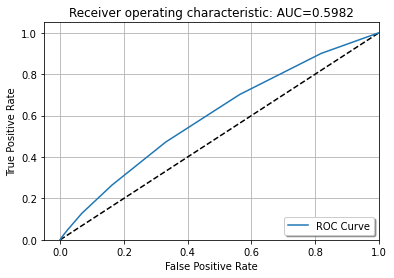

In [24]:
# assess random forest performance 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = model_classifier.score(test_X, test_y)

# get roc/auc info
Y_score = model_classifier.predict_proba(test_X)[:,1]  # prob for 1 - default --- which means get prediction for probabilities 
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(test_y, Y_score)   # use actual y and predicted y to draw ROC curve 

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(6,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
plt.grid(True)
plt.plot(fpr, tpr, label='ROC Curve')        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

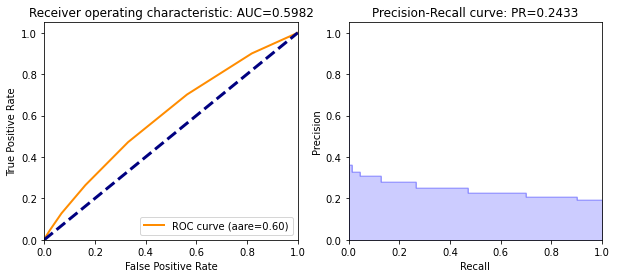

In [25]:
# OPTION 2 of plotting ROC AUC, P-R Curve 
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# get roc/auc info
Y_score = model_classifier.predict_proba(test_X)[:,1]  # prob for 1 - default --- which means get prediction for probabilities 
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(test_y, Y_score)   # use actual y and predicted y to draw ROC curve 

roc_auc = dict()
roc_auc = auc(fpr, tpr)

average_precision = average_precision_score(test_y, Y_score)

# plotting
plt.figure(figsize=(10,4))

# ROC
plt.subplot(1,2,1)
plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
plt.legend(loc='lower right')

# Precision-Recall
plt.subplot(1,2,2)
precision,recall,_ = precision_recall_curve(test_y,Y_score)
plt.step(recall,precision,color='b',alpha=0.2,where='post')
plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
plt.show()


## 5. SHAP values 

### 5.1 SHAP explanation force plots 

### Individual SHAP Value Plot — Local Interpretability

### Let's get SHAP values for single observation and prediction

- the SHAP package has explainers for every type of model.
- shap.DeepExplainer works with Deep Learning models.
- shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

In [26]:
# we only make the prediction for the 1st row in test data firstly
data_for_prediction = test_X.iloc[0]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
data_for_prediction_array

array([[ 1.5000e+01,  1.6000e+01,  7.0000e+00,  7.0000e+00, -9.8000e+01,
         8.4000e+01,  2.4000e+01,  1.2000e+01, -9.8000e+01,  3.0000e+00,
         2.5700e+02,  8.0000e+00,  3.0000e+00,  7.0000e+00,  6.0000e+00,
        -1.0000e+00,  9.9500e+02,  1.0000e+00,  5.2570e+04,  6.1788e+04,
        -9.8000e+01,  1.8000e+01,  2.0000e+00,  5.6000e+01,  4.3470e+03,
         1.1600e+02,  2.0000e+00,  2.3980e+03,  1.5026e+04,  7.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00]])

In [27]:
# make predictions 
# The observation is 10% likely to default, the actual value is 0, our prediction makes sense. 
model_classifier.predict_proba(data_for_prediction_array)

array([[0.9, 0.1]])

In [28]:
# import package used to calculate Shap values
import shap  
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_classifier)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

### 5.1.1.SHAP Value Plot for the 1st observation in test data

We predicted 0.1, whereas the base_value is 0.1947. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from CR015 being 6. Though the value has a meaningful effect decreasing the prediction.


To explain in details: 

* CR015 has the biggest impact, which is the MONTH_CREDIT_CARD_MOB_MAX, it decreased the possibility for the variable to be default. 

* CD131 has the 2nd biggest impact, which is the CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOU, it decreased the possibility for the variable to be default. 

* TD009 which is TD_CNT_QUERY_LAST_3MON_P2P, increased the likelihood to be default. 


In [29]:
shap.initjs()
# The shap_values object above is a list with two arrays. The first array is the SHAP values for not default, and the second array is the list of SHAP values for default. We will pull out shap_values[1], to get predictions  for default. 
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Because we need to provide explaination for 3 other observations, We will write the process in a function

In [30]:
shap.initjs()
def shap_plot(j):
    data_for_prediction = test_X.iloc[j]  # use 1 row of data here. Could use multiple rows if desired
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
    explainer = shap.TreeExplainer(model_classifier)
    # Calculate Shap values
    shap_values = explainer.shap_values(data_for_prediction)
    plot = shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)
    return(plot)

### 5.1.2. SHAP Value Plot for the 2nd observation 
To explain in details: 

* AP003 has the biggest impact, which is the EDUCATION LEVEL, it decreased the possibility for the variable to be default. 

* CD152 has the 2nd biggest impact, which is the LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBO, it increased the possibility for the variable to be default. 

* CD008 which is LEN_TOTAL_INBOUND_CALLS_LAST_1MON, it increased the likelihood to be default. 

In [31]:
# here is the SHAP Value Plot for the 2nd observation 
shap_plot(1)

### 5.1.3 SHAP Value Plot for the 3rd observation 
To explain in details: 

* TD010 has the biggest impact, which is the TD_CNT_QUERY_LAST_3MON_SMALL_LOAN, it increased the possibility for the variable to be default. 

* TD013 has the 2nd biggest impact, which is the TD_CNT_QUERY_LAST_6MON_P2P, it increased the possibility for the variable to be default. 

* PA028 which is AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS, increased the likelihood to be default. 


In [32]:
# here is the SHAP Value Plot for the 3rd observation 
shap_plot(2)

### 5.1.4 SHAP Value Plot for the 4th observation 
To explain in details: 

* TD013 has the biggest impact, which is the TD_CNT_QUERY_LAST_6MON_P2P, it decreased the possibility for the variable to be default. 

* AP003 has the 2nd biggest impact, which is the EDUCATION LEVEL, it decreased the possibility for the variable to be default. 

* PA022 which is DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_H, increased the likelihood to be default. 


In [33]:
# here is the SHAP Value Plot for the 4th observation 
shap_plot(3)

In [34]:
# we use this dictionary to find description for each corresponding column code
Variables_Dictionary[Variables_Dictionary['var'].isin(df3.columns)]

,var,description
4,AP002,CODE_GENDER
5,AP003,CODE_EDUCATION
6,AP004,LOAN_TERM
8,AP006,OS_TYPE
15,MB005,YR_PHONE_ACTIVE
20,CR004,CNT_QUERY_TIME_LAST_1MON
21,CR005,CNT_QUERY_TIME_LAST_2MON
25,CR009,AMT_LOAN_TOTAL
31,CR015,MONTH_CREDIT_CARD_MOB_MAX
33,CR017,SCORE_DEBIT_CARD_TOTAL_AMT


## 5.2 SHAP Feature Importance

### Variable Importance Plot — Global Interpretability

Variable ImportancePlot is very intuitive, we can see how important each predictor to the final result, from model's perspective. Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data. 

### extensive descriptions for your top 5 variables.
We sort the features by decreasing importance and plot them. The following figure shows the SHAP feature importance for the random forest trained for predicting default. From the graph, we can see the top 5 most important variables are: 

* AP003: EDUCATION Level, the higher education level, the less likely the applicant will default 

* TD013: TD_CNT_QUERY_LAST_6MON_P2P, the more queries from other P2P platforms in the past 6 months, the more likely the applicant will default 

* AP004: LOAN_TERM, the longer the loan term, the more likely the applicant will default 

* TD009: TD_CNT_QUERY_LAST_3MON_P2P, the more queries from other P2P platforms in the past 3 months, the more likely the applicant will default 

* MB005: YR_PHONE_ACTIVE: more years of the phone stay active, the less likely the applicant will default 

In [40]:
shap_values = shap.TreeExplainer(model_classifier).shap_values(train_X[1:3000])
shap_values

[array([[-1.38462549e-02, -9.57664872e-03, -1.51072181e-03, ...,
          1.74145486e-04, -2.78224968e-03, -9.46617973e-05],
        [ 6.98663448e-03,  1.13066257e-02,  8.25941380e-03, ...,
         -1.26304498e-05,  3.43219279e-04, -2.63604567e-03],
        [ 9.82648479e-03,  1.99806250e-02,  2.09288501e-02, ...,
          3.97330318e-04,  1.54429906e-03,  4.41358337e-05],
        ...,
        [ 1.68820129e-02,  1.09321035e-02,  2.26827854e-05, ...,
          1.54475562e-04,  3.83015772e-04, -1.00837715e-03],
        [ 1.53516948e-02,  3.80004384e-02,  2.70627885e-02, ...,
          3.96087890e-04,  3.69871550e-03, -7.01606657e-04],
        [ 1.01579629e-02,  4.35887955e-02,  2.31223764e-02, ...,
          2.71405870e-04,  1.23325043e-04,  1.97805466e-03]]),
 array([[ 1.38462549e-02,  9.57664872e-03,  1.51072181e-03, ...,
         -1.74145486e-04,  2.78224968e-03,  9.46617973e-05],
        [-6.98663448e-03, -1.13066257e-02, -8.25941380e-03, ...,
          1.26304498e-05, -3.43219279e

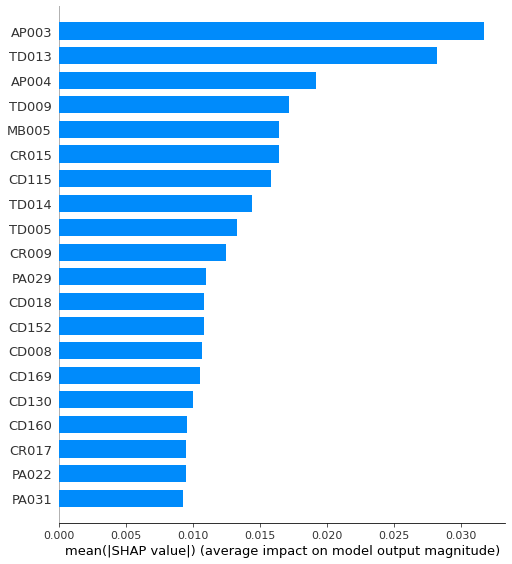

In [47]:
shap.summary_plot(shap_values[1], train_X[1:3000], plot_type="bar")

## 5.3 Summary Plot

The feature importance plot is useful, but contains no information beyond the importances. For a more informative plot, we will next look at the summary plot.

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

To interpret the following graph: 

** higher AP003, which is the education level, has a nagative impact on default

** higher TD013, which is the the number of queries from other P2P platforms in the past 6 months, has a positive impact on default

** higher AP004, which is the Loan term  has a positive impact on default


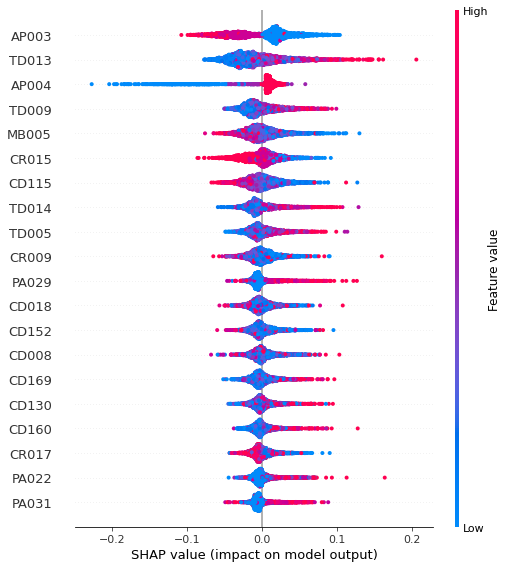

In [50]:
# further show the positive and negative relationships of the predictors with the target variable.
shap.summary_plot(shap_values[1], train_X[1:3000])

## 5.4 SHAP Dependence Plot — Global Interpretability

To see the exact form of the relationship, we have to look at SHAP dependence plots.

SHAP feature dependence might be the simplest global interpretation plot: 1) Pick a feature. 2) For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. 3) Done.

The interaction effect is the additional combined feature effect after accounting for the individual feature effects.

**Graph interpretation for TD013**

The following plot shows there is an approximately linear and positive trend between TD013, which is the the number of queries from other P2P platforms in the past 6 months and the target variable 'loan default', and TD013 interacts with TD009 most, which is TD_CNT_QUERY_LAST_3MON_P2P.

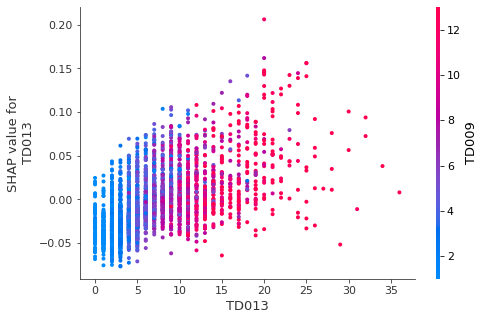

In [51]:
# TD013: LOAN_TERM
shap.dependence_plot('TD013', shap_values[1], train_X[1:3000])

**Graph interpretation for AP003**

The following plot shows there is a negative trend between AP003, the education level and the target variable 'loan default', and AP003 interacts with TD009 most, which is TD_CNT_QUERY_LAST_3MON_P2P.

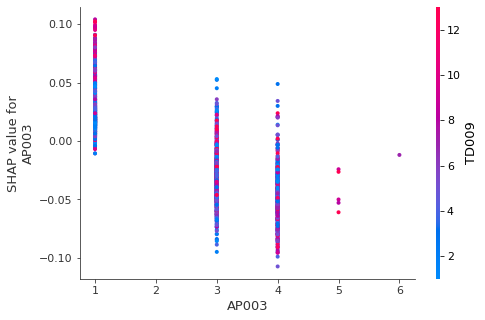

In [52]:
# AP003 is CODE_EDUCATION
shap.dependence_plot('AP003', shap_values[1], train_X[1:3000])

**Graph interpretation for MB005**

The following plot shows there is a negative trend between MB005, YR_PHONE_ACTIVE and the target variable 'loan default', and AP003 interacts with AP003 most, which is the education level.

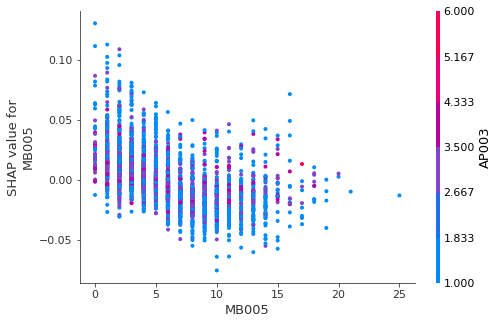

In [54]:
# AP004 is loan term
shap.dependence_plot('MB005', shap_values[1], train_X[1:3000])

**Reference**

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

https://www.kaggle.com/dansbecker/shap-values

https://christophm.github.io/interpretable-ml-book/shap.html

